# Tracking a Spherical Colloid with Holopy

The aim of this Jupyter Notebook is to use the Holopy (see GitHub: manoharan-lab/holopy) repository to obtain the 3D trajectory of a spherical colloid from an experimental Mie-holography video. 

Two main objectives: 
 - compare Holopy and Pylorenzmie (see Github: davidgrier/pylorenzmie).
 - grasp how Holopy works.

# Importations & Auxiliary Functions

## Importations

In [1]:
import numpy as np

import imageio

import pandas as pd
import seaborn as sns

import os 
import sys
import copy
from tqdm import tqdm

In [2]:
import utilities

In [3]:
# Holopy
import holopy as hp
# Utilities
from holopy.core.io import load_average
from holopy.core.process import bg_correct, subimage, normalize, center_find
# Define Scatterers
from holopy.scattering import Sphere #, Spheres, Cylinder
# from holopy.scattering.scatterer import Spheroid
# from holopy.scattering.scatterer import Capsule
# Theories
from holopy.scattering import Mie
from holopy.scattering.theory import Tmatrix
# Compute holograms and fit
from holopy.scattering import calc_holo
# from holopy.inference import CmaStrategy
from holopy.inference import prior, ExactModel, NmpfitStrategy

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=600)

## Auxiliary Function: azimutal average

In [5]:
# Adapted from pylorenzmie

def aziavgstd(data, center):
    '''Azimuthal average and standard deviation of data about center
    
    Parameters
    ----------
    data : array_like
        image data
    center : tuple
        (x_p, y_p) center of azimuthal average

    Returns
    -------
    avg : array_like
        One-dimensional azimuthal average of data about center
    std : array_like
        Standard deviation from the mean
    '''
    x_p, y_p = center
    ny, nx, _ = data.shape
    x = np.arange(nx) - x_p
    y = np.arange(ny) - y_p
    
    d = data.ravel()
    r = np.hypot.outer(y, x).astype(int).ravel()
    nr = np.bincount(r)
    avg = np.bincount(r, d) / nr
    std = np.sqrt(np.bincount(r, (d - avg[r])**2) / nr)
    rad = np.arange(len(avg))
    return rad, avg, std

# Inputs

In [6]:
# Optics & Camera
spacing = 0.05799
fps = 100

In [7]:
# Light
illum_polarization = (1, 0)
illum_wavelen = 0.532
medium_index = 1.33

In [8]:
# Path to an experimental video 
vid_path = './vid_PS_diffusing/Basler_acA1920-155um__22392621__20230310_132632377.mp4'

In [9]:
vid = utilities.video_reader(vid_path)

In [12]:
n_start = 0
n_stop = vid.get_length()
print(n_stop)

126443


# Before Experimental Images: a Theoretical Image

In [13]:
h = 500 # px

# Create the theoretical image
theory = Mie
detector = hp.detector_grid(shape=h, spacing=spacing)
s1 = Sphere(center=(h//2*spacing, h//2*spacing, 12), n = 1.59, r = 1.48) # x, y, z in um
holo = calc_holo(detector, s1, 
                 medium_index, illum_wavelen, illum_polarization, 
                 theory=theory, 
                )

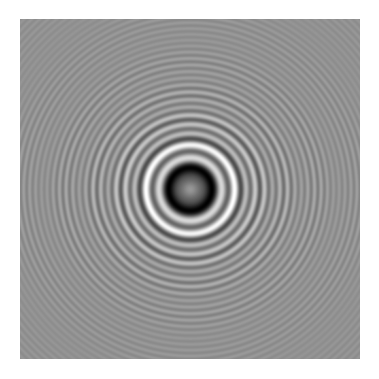

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))
ax.imshow(holo, cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
# Find approximate center
yc, xc = center_find(holo, centers=1, threshold=0.5, blursize=3)

In [16]:
# Crop
hc = 200
holo_c = subimage(holo, [yc,xc], hc)
holo_c = normalize(holo_c)

In [17]:
# holo_c

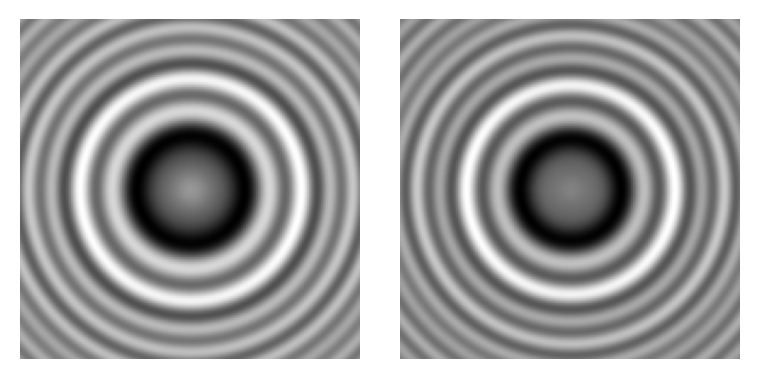

In [18]:
# Initial guess
guess_sphere = Sphere(center=[yc*spacing, xc*spacing, 11], r=1.49, n=1.59)
holo_guess = calc_holo(holo_c, guess_sphere)

# Plot
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10/2.54,5/2.54))
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_guess.data, cmap='gray')
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [19]:
%%time

# Fit 
parameters_to_fit = ['x', 'y', 'z', 'r', 'n']

# Define the fitting strategy
fit_strategy = NmpfitStrategy()
percent_px = 0.1
fit_strategy.npixels = int(percent_px * hc ** 2)

# Fit
fit_result = hp.fit(holo_c, guess_sphere, parameters=parameters_to_fit, strategy=fit_strategy)

CPU times: user 1.02 s, sys: 4.41 ms, total: 1.02 s
Wall time: 1.02 s


In [20]:
holo_f = fit_result.hologram

{'n': 1.589817918341741, 'r': 1.4775545338827927, 'x': 14.497424018138682, 'y': 14.497310696275717, 'z': 11.993734649644995, 'alpha': 1.0}


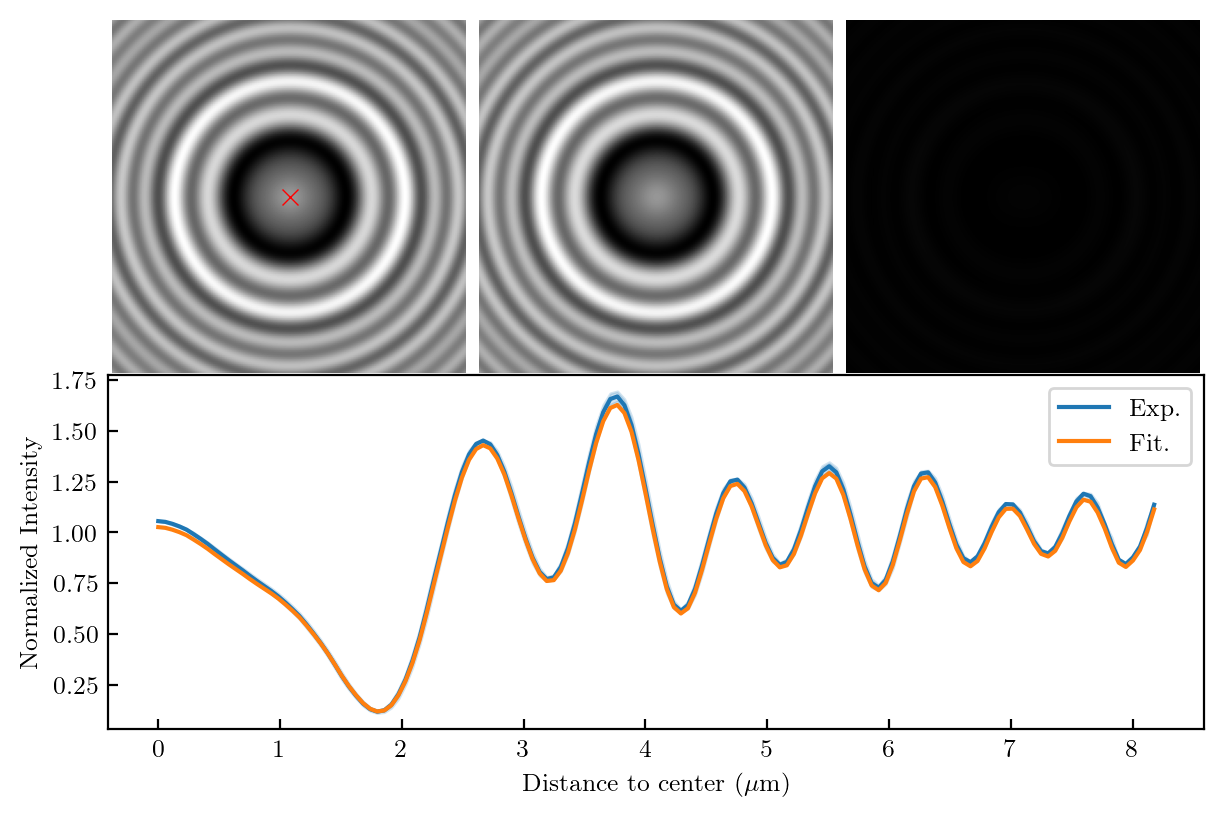

In [21]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

# Compute the Background

In [22]:
_, background = vid.get_background(n=20, first_im=n_start, last_im=n_stop)
background += 1
vid.background += 1

(21, 1200, 1200)


100%|█████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.92it/s]


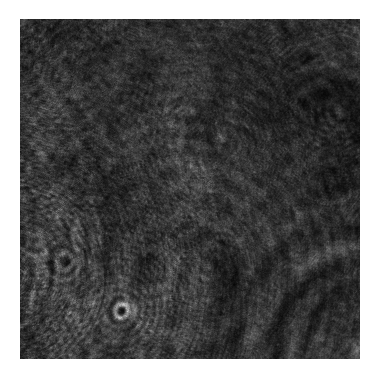

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54, 5/2.54))
ax.imshow(background, cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.show()
# fig.savefig('background.pdf')

In [24]:
background.shape

(1200, 1200)

In [25]:
%%time 

# Create a Holopy object with the appropriate dimensions

# Size of the box
h = background.shape[0]

# Set the theory
theory = Mie
# Define the detector
detector = hp.detector_grid(shape=h, spacing=spacing)
# Define the scatterer
s1 = Sphere(center=(h//2*spacing, h//2*spacing, 12), n = 1.59, r = 1.48) # x, y, z in um
# Define the holopy object
background = calc_holo(detector, s1, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)
# Replace the data by the experimental image
background.data[:,:,0] = copy.deepcopy(vid.background)

CPU times: user 7.2 s, sys: 95.1 ms, total: 7.29 s
Wall time: 7.24 s


# Work On One Image

In [56]:
index = 50000
# Get the image 
im_raw = vid.get_image(index)
# Remove background and normalize 
im_fin = utilities.normalize(im_raw, vid.background, dark_count=0)

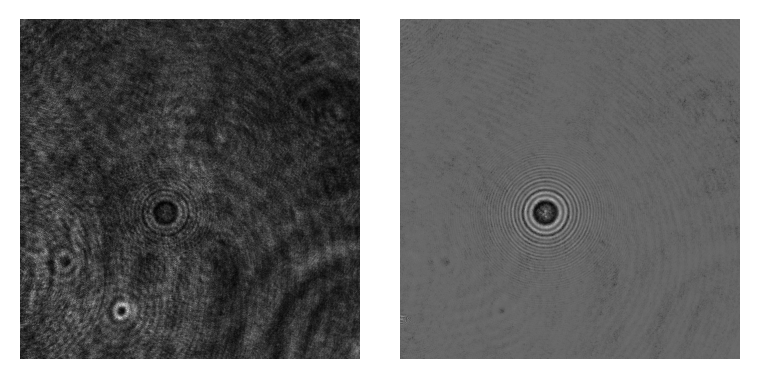

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))
axes[0].imshow(im_raw, cmap='gray')
axes[1].imshow(im_fin, cmap='gray')
for i, ax in enumerate(axes):
    ax.axis('off')
plt.tight_layout()
plt.show()

In [58]:
# imageio.imsave('test.jpg', im_raw)

In [59]:
%%time

# Create a Holopy object with the appropriate dimensions
# Set the theory
theory = Mie
# Define the detector
detector = hp.detector_grid(shape=h, spacing=spacing)
# Define the scatterer
s1 = Sphere(center=(h//2*spacing, h//2*spacing, 12), n = 1.59, r = 1.48) # x, y, z in um
# Define the holopy object
holo_raw = calc_holo(detector, s1, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)
# Replace the data by the experimental image
holo_raw.data[:,:,0] = copy.deepcopy(im_raw)

CPU times: user 7.18 s, sys: 73.9 ms, total: 7.26 s
Wall time: 7.22 s


In [60]:
holo = bg_correct(holo_raw, background, df=None)

In [61]:
# Find approximate center
xc, yc = center_find(holo, centers=1, threshold=0.5, blursize=3)
# Crop and normalize
hc = 200
holo_c = subimage(holo, [xc, yc], hc)
holo_c = normalize(holo_c)

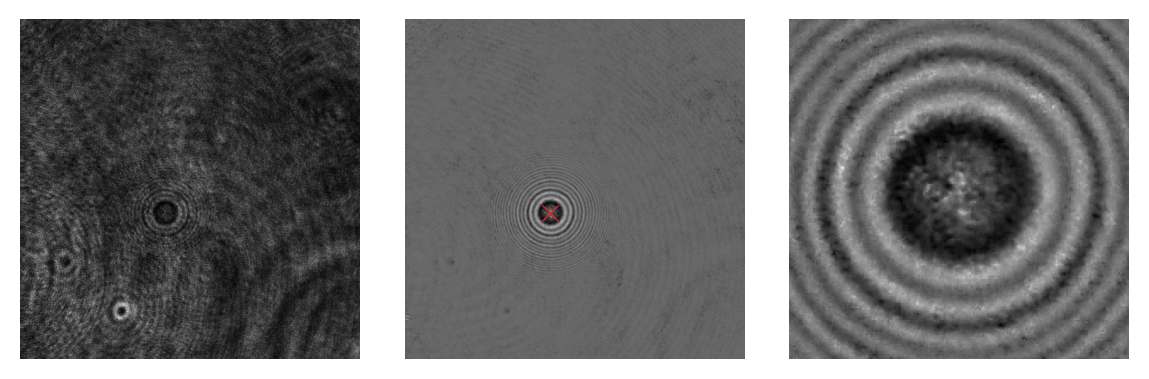

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(15/2.54, 5/2.54))
axes[0].imshow(holo_raw.data, cmap='gray')
axes[1].imshow(holo.data, cmap='gray')
axes[1].plot(yc, xc, marker='x', mec='tab:red')
axes[2].imshow(holo_c.data, cmap='gray')
for i, ax in enumerate(axes):
    ax.axis('off')
plt.tight_layout()
plt.show()

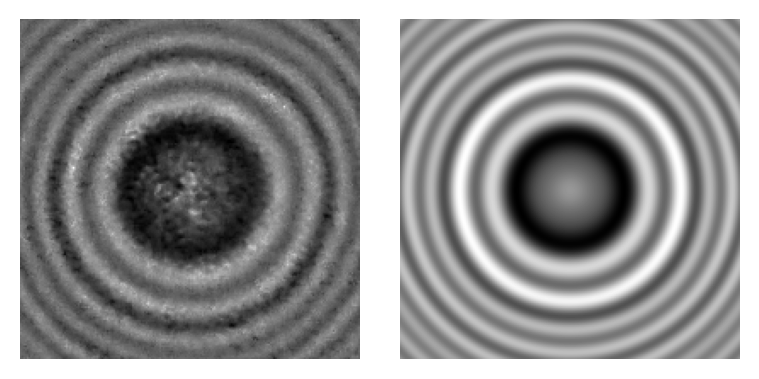

In [63]:
# Initial guess
guess_sphere = Sphere(center=[xc*spacing, yc*spacing, 12], r=1.48, n=1.59)
holo_guess = calc_holo(holo_c, guess_sphere)

# Plot
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10/2.54,5/2.54))
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_guess.data, cmap='gray')
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [64]:
%%time

# Fit 
parameters_to_fit = ['x', 'y', 'z', 'r', 'n']

# Define the fitting strategy
fit_strategy = NmpfitStrategy()
percent_px = 0.2
fit_strategy.npixels = int(percent_px * hc ** 2)

# Fit
fit_result0 = hp.fit(holo_c, guess_sphere, parameters=parameters_to_fit, strategy=fit_strategy)

CPU times: user 3.17 s, sys: 25.9 ms, total: 3.2 s
Wall time: 3.18 s


{'n': 1.581731482919782, 'r': 1.48007082082341, 'x': 39.61820758460715, 'y': 29.779890144728263, 'z': 13.611459715687971, 'alpha': 1.0}


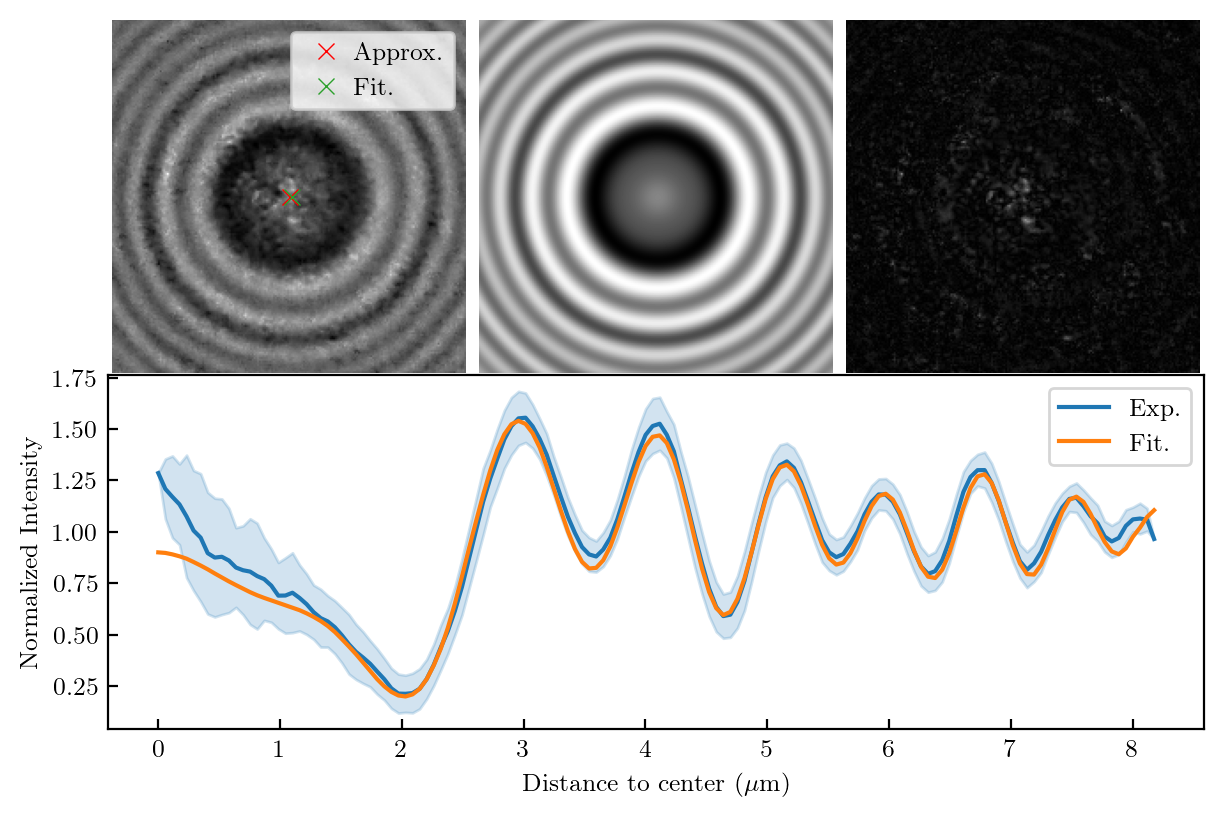

In [65]:
print(fit_result0.parameters)

holo_f = fit_result0.hologram

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, ls='', marker='x', mec='r', label='Approx.')
ax1.plot(fit_result0.parameters['y']/spacing - yc + hc//2, fit_result0.parameters['x']/spacing - xc + hc//2, ls='', marker='x', mec='tab:green', label='Fit.')
ax1.legend(handletextpad=0.1)

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [66]:
# /!\ Switching between x and y compared to vid.
# x from Holopy = usual y

# fit_result gives positions in the initial image

In [67]:
def full2crop(holo, hc=200):
    # Find approximate center
    xc, yc = center_find(holo, centers=1, threshold=0.5, blursize=3)
    # Crop and normalize
    holo_c = subimage(holo, [xc, yc], hc)
    holo_c = normalize(holo_c)
    return holo_c, xc, yc

In [68]:
# Where to fit
start = index #40000
stop = index + 10 #41000
frequency = 1

# Initial guess = result of the previous fit
guess_sphere = Sphere(center=[fit_result0.parameters['x'], fit_result0.parameters['y'], fit_result0.parameters['z']], r=fit_result0.parameters['r'], n=fit_result0.parameters['n'])

# Initialize storage 
storage = pd.DataFrame(index=np.arange(start, stop, frequency), columns=parameters_to_fit)

for i in tqdm(range(start, stop, frequency)):
    im_raw = vid.get_image(i)
    # Replace the data by the experimental image
    holo_raw.data[:,:,0] = copy.deepcopy(im_raw)
    # Remove the background
    holo = bg_correct(holo_raw, background, df=None)
    # Crop and normalize
    holo_c, xc, yc = full2crop(holo_raw, hc=hc)
    # Fit 
    fit_result = hp.fit(holo_c, guess_sphere, parameters=parameters_to_fit, strategy=fit_strategy)
    # Store the data 
    temp = fit_result.parameters
    temp.pop('alpha')
    for key, value in temp.items():
        storage.loc[i,key] = value
    # Update guess
    # guess_sphere = Sphere(center=[fit_result.parameters['x'], fit_result.parameters['y'], fit_result.parameters['z']], r=fit_result0.parameters['r'], n=fit_result0.parameters['n'])
    guess_sphere = Sphere(center=[xc*spacing, yc*spacing, fit_result.parameters['z']], r=fit_result0.parameters['r'], n=fit_result0.parameters['n'])

100%|█████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


In [80]:
storage.head()

,x,y,z,r,n
50000,39.86207,29.704815,13.29791,1.48648,1.60431
50001,59.73162,20.731149,12.616077,1.477332,1.527652
50002,59.700737,20.643271,11.39443,1.306883,1.553824
50003,59.717973,20.706598,10.902791,1.51815,1.518055
50004,59.717759,20.739059,10.374528,1.464495,1.52023


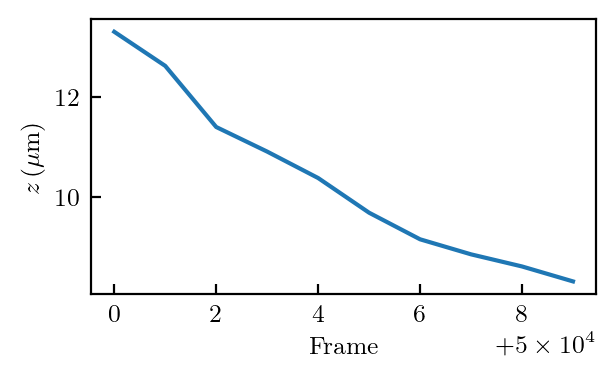

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))
ax.plot(storage.index, storage['z'])
ax.set(xlabel=r'Frame', ylabel=r"$z \, (\mathrm{\mu m})$")
plt.tight_layout()
plt.show()

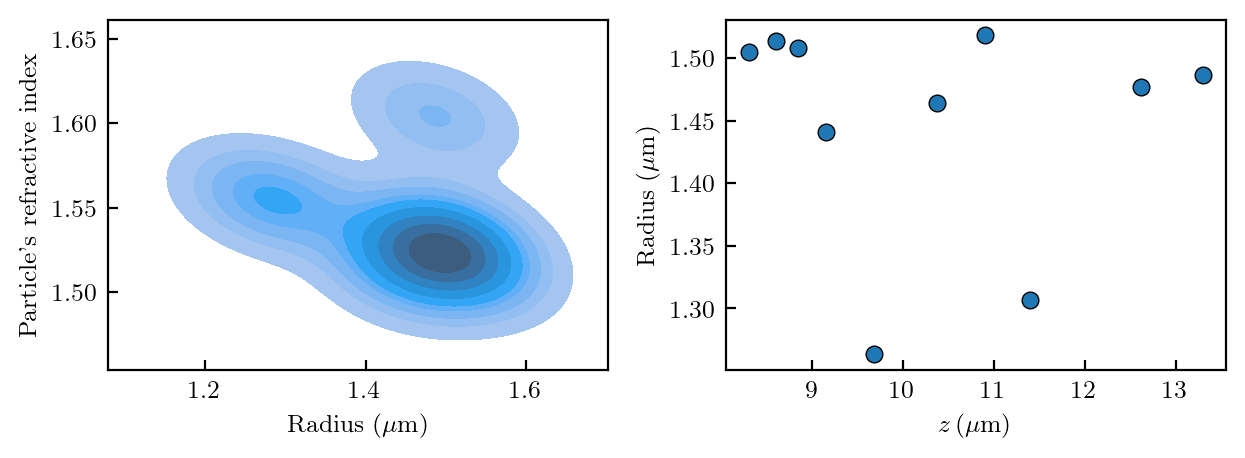

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(16/2.54, 6/2.54))
sns.kdeplot(data=storage, x='r', y='n', hue=None, fill=True, ax=axes[0]) #thresh=.2, levels=5)
axes[0].set(xlabel=r'Radius ($\mathrm{\mu m}$)', ylabel="Particle's refractive index")
axes[1].plot(storage['z'], storage['r'], ls='', marker='o')
axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'Radius ($\mathrm{\mu m}$)')
plt.tight_layout()
plt.show()